# Challenge

### By - LI Yanting

## 1. Load data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

In [2]:
# Critere de performance
def compute_pred_score(y_true, y_pred):
    y_pred_unq =  np.unique(y_pred)
    for i in y_pred_unq:
        if((i != -1) & (i!= 1) & (i!= 0) ):
            raise ValueError('The predictions can contain only -1, 1, or 0!')
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

In [3]:
X_train_fname = 'training_templates.csv'
y_train_fname = 'training_labels.txt'
X_test_fname  = 'testing_templates.csv'
y_train = np.loadtxt(y_train_fname, dtype=np.int)
X_train = pd.read_csv(X_train_fname, sep=',', header=None).values
X_test  = pd.read_csv(X_test_fname,  sep=',', header=None).values

## 2. Data Preprocessing

Data preprocessing is necessary to build a good training set. In general, this step should include sample selection and feature selection. In sample selection, some outlier data should be removed from the training set; In feature selection, some "bad" features should not be considered in order to dicrease the dim of the data. If the model gives all features the same importance, it will lead to over-fitting, the generalization ability of unknown data will be poor.

### 2-1 Standardization

In [36]:
# Standardization
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### 2-2 Processing Samples with KNN

This step is to select the training samples more likely to test set:
For each sample in the test dataset, we select 50 nearest samples from the original training set to generate a new training set. (After an 'unique' operation, this new training set contains about 90000 samples.) 

In [19]:
# Sample Selection: KNN
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(X_train_std)
distances, indices = nbrs.kneighbors(X_test_std)
new_indices = np.ravel(indices)
uni_indices = np.unique(indices)
print nbrs
X_train_unique = X_train_std[uni_indices]
y_train_unique = y_train[uni_indices]
print "X_train_unique Shape: ", X_train_unique.shape
print "y_train_unique Shape: ", y_train_unique.shape
# Save new train set: X_train_unique and y_trian_unique
np.savetxt("X_train_unique_50.csv", X_train_unique, fmt='%.6e', delimiter=',')
np.savetxt("y_train_unique_50.txt", y_train_unique, fmt='%d')

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=30, p=2, radius=1.0)
X_train_unique Shape:  (73596, 128)
y_train_unique Shape:  (73596,)


### 2-3 Processing Features with PCA

This step should contain two parts: 
- select "good" features
- PCA

For feature selection, sklearn.SelectKBest and xgboost.plot_importance have been tried, but unfortunately, in SelectKBest, after trying all three types of function(chi2, mutual_info_classif and f_classif), there isn't a better result; there also remains some problems with xgboost.plot_importance to solve. Therefore, this part remains a feature selection to be completed.

For the parameters in PCA, the purpose of whitening is to keep several eigenvalues of the output independent of each other. Svd_sover 'auto' could choose automaticly a solver most suitable for current situation.

In [42]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=128, whiten=True, svd_solver='auto')
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_std)

For training a model and getting a evaluation of the model, the training set is splitted into X_train_split and X_test_split with a test_size of 0.2. For a large training set, this test_size could be smaller as 0.05 or even less, but in order to ensure enough test data to evaluate the model, here 20% of the data is chosen to be test set.

In [43]:
# split data into train and test sets
from sklearn.cross_validation import train_test_split
seed = 0
test_size = 0.2
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_pca, y_train_unique, 
                                                                test_size=test_size, random_state=seed)
print X_train_split.shape, y_train_split.shape
print X_test_split.shape, y_test_split.shape
print np.mean(y_train_split)

(70218, 128) (70218,)
(17555, 128) (17555,)
0.0793528724828


## 3. Training

This function is to judge when it should return 0 as an uncertainty. The parameter threshold means the difference between the classification result with a higher probability and the one with a lower probability. In next step, a best threshold is searched from 0 to 0.99 to ensure that the general score to be almost the highest.

In [21]:
def predict(y_predict_proba, threshold=0.54):
    y_predict = np.zeros((len(y_predict_proba)), dtype=np.int)
    y_diff = np.add(y_predict_proba[:,1], -y_predict_proba[:,0])
    y_predict = np.piecewise(y_diff,[y_diff<(-threshold),y_diff>threshold],[-1,1]).astype(int)
    return y_predict

### 3-1 Bagging with MLP

After trying single MLP, SVC, xgboost classifier, Random Forest and Bagging with MLP, the last model is chosen according to their testing score. An obstacle here is the tune of xgboost. In theory, xgboost should give a good performance but it takes too much time to tune and here remains some work to explore.

For Bagging with MLP, it is difficult to find a relationship between the hidden_layer_sizes and the performance, but 2 layer is enough. n_estimators could be relatively large as 40 to give a more 'correct' result of classification. Max_samples and max_features could be relatively small to avoid over-fitting.

In [44]:
import time
start = time.clock()
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
n_estimators = 40
bagging = BaggingClassifier(base_estimator=MLPClassifier(solver='lbfgs', alpha=1e-4, 
                                                         hidden_layer_sizes=(200,200), random_state=27),
                           n_estimators=n_estimators, max_samples=0.62, max_features=0.62, n_jobs=-1)
bagging.fit(X_train_split, y_train_split)
y_inter = bagging.predict_proba(X_test_split)
end = time.clock()
print "Running Time: ",end-start

Running Time:  1.754916


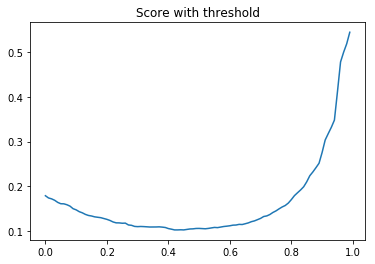

Score sur le train : 0.102363998861


In [45]:
# To select a best Threshold:
score_min = 1
threshold = 0.7
score = np.zeros(100)
i=0
plt.figure()
for x in np.linspace(0, 0.99, num=100):
    y_pred_train = predict(y_inter,x)
    score[i] = compute_pred_score(y_test_split, y_pred_train)
    if score[i] < score_min:
        score_min = score[i]
        threshold = x
#     print('Threshold %s \t Score : %s' %(x,score[i]))
    i=i+1
plt.plot(np.linspace(0, 0.99, num=100),score)
plt.title('Score with threshold')
plt.show()

# Play with the best threshold
y_pred_train = predict(y_inter,threshold)
score = compute_pred_score(y_test_split, y_pred_train)
print('Score sur le train : %s' % score)

### 3-2 Play with the 'real data'

After training a model, here we use all the selected samples in the training set to train a new model for predicting. And then predict the X_test after this test set being processed with the previous steps.

In [30]:
import time
start = time.clock()
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
n_estimators = 40
bagging = BaggingClassifier(base_estimator=MLPClassifier(solver='lbfgs', alpha=1e-4, 
                                                         hidden_layer_sizes=(200,200), random_state=27),
                           n_estimators=n_estimators, max_samples=0.62, max_features=0.62, n_jobs=-1)
bagging.fit(X_train_pca, y_train_unique)
y_inter = bagging.predict_proba(X_test_pca)

# Play with the best threshold
y_pred = predict(y_inter,0.45)
np.savetxt('y_pred_bagging.txt', y_pred, fmt='%d')
end = time.clock()
print "Running Time: ",end-start

Running Time:  1.90521
